# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

Loan defaults pose a significant threat to a bank’s financial health. For instance, while the mortgage delinquency rate in the United States has been gradually declining since the COVID-19 pandemic, as of February 2024, the overall delinquency rate was 2.8%. Such non-performing assets (NPAs) erode profitability and constrain the bank’s ability to extend new credit. Moreover, the manual loan approval process is labor-intensive and susceptible to human errors and biases, leading to potential misjudgments in loan approvals or rejections. Addressing this issue is crucial to enhance operational efficiency, reduce financial risks, and uphold equitable lending practices.

### **The objective:**

The goal is to modernize and streamline the loan approval process by leveraging machine learning classification methods, capable of as accurately predicting loan defaults as possible using available data. This model should:
 - Enhance operational efficiency by automating repetitive tasks and reducing the time spent on manual credit assessments.
 - Mitigate risk by identifying high-risk applicants before loan issuance.
 - Ensure fairness by eliminating biases that could disadvantage certain demographics, thus aligning with federal regulation, legal requirements and ethical standards.
 - Ensure Regulatory Compliance by aligning with legal frameworks such as the Equal Credit Opportunity Act, which mandates non-discriminatory lending practices and requires transparent justifications for adverse decisions.
 - Enable data-driven decision-making by providing interpretable insights into why a loan is approved or rejected, allowing for greater transparency and trust with stakeholders.
 - Promote Fairness by eliminating biases inherent in human judgment, ensuring equitable treatment of all applicants.
 - The model should be extensible to learn from future loan defaults

### **The key questions:**

 - Which applicants are likely to default on their loans? Identifying potential defaulters enables targeted risk management strategies.
 - What factors are most critical in assessing an applicant’s creditworthiness? Determining key indicators such as income stability, debt-to-income ratio, and credit history informs more accurate evaluations.
 - How can the loan approval process be optimized for efficiency and fairness? Implementing automated, data-driven systems can streamline operations while upholding ethical standards.
 - How can the model ensure compliance with regulatory requirements? Providing interpretable justifications for loan decisions is essential to meet legal obligations and maintain transparency.
 - How can historical biases be prevented from influencing the model? Ensuring the model is trained on unbiased data is crucial to avoid perpetuating past discriminatory practices.

### **The problem formulation**:

Data science enables us to:
 - Predict defaults: Use predictive analytics to assess the likelihood of applicants failing to meet their repayment obligations.
 - Automate Decision-Making: Replace subjective human assessments with objective, data-driven evaluations, enhancing consistency and speed.
 - Identify Key Risk Factors: Analyze data to pinpoint variables that significantly influence default risk, such as high debt-to-income ratios or unstable employment histories.
 - Ensure Model Interpretability: Develop transparent models that provide clear explanations for their decisions, facilitating compliance with regulations and building stakeholder trust.
 - Mitigate Bias: Implement fairness algorithms to detect and correct biases, ensuring the model’s decisions are equitable and just.

By solving this problem, the bank not only reduces risk but also transforms its loan approval system into a benchmark for innovation and inclusivity.

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [6]:
import importlib

# Ignore warning messages only
import warnings
warnings.filterwarnings("ignore")

# Importing the Pandas library for data manipulation and analysis
import pandas as pd

# Importing the NumPy library for numerical operations
import numpy as np
import math

# Importing Matplotlib for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Logistic Regression model from scikit-learn for binary classification
from sklearn.linear_model import LogisticRegression

# Importing Decision Tree Classifier from scikit-learn for classification tasks
from sklearn.tree import DecisionTreeClassifier

# Importing Random Forest Classifier from scikit-learn for ensemble learning
from sklearn.ensemble import RandomForestClassifier

# Importing train_test_split function to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# import custom ds functions
from my_data_science_package.data_processing import summarize_dataframe, impute_missing_values, calculate_corr_and_vif, decode_categorical_columns
from my_data_science_package.data_visualization import histogram_boxplot, plot_binned_features, plot_grouped_barplots
from my_data_science_package.utils import segregate_columns_by_dtype
from my_data_science_package.model_evaluation import chi_squared_test

In [7]:
from my_data_science_package import data_visualization, data_processing  # Replace with your module
importlib.reload(data_visualization)
importlib.reload(data_processing)

<module 'my_data_science_package.data_processing' from '/Users/vivekmagar/Documents/GitHub/ADSP_Capstone/analytiqbit/my_data_science_package/data_processing.py'>

## **Data Overview**
- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values

In [9]:
# Import data from CSV file into a Pandas DataFrame
loadings = pd.read_csv('../data/hmeq.csv')

In [10]:
# Make a copy of the original dataframe for processing, so the original data stays intact
default = loadings.copy()

In [11]:
# Update column names for improved readability
default.rename(columns={
    'BAD': 'client_defaulted_on_loan',  # 1 = Client defaulted on loan, 0 = loan repaid
    'LOAN': 'loan_amount_approved',      # Amount of loan approved
    'MORTDUE': 'mortgage_amount_due',    # Amount due on the existing mortgage
    'VALUE': 'property_current_value',    # Current value of the property
    'REASON': 'loan_request_reason',      # Reason for the loan request
    'JOB': 'applicant_job_type',          # Type of job that loan applicant has
    'YOJ': 'years_at_present_job',        # Years at present job
    'DEROG': 'major_derogatory_reports',  # Number of major derogatory reports
    'DELINQ': 'delinquent_credit_lines',  # Number of delinquent credit lines
    'CLAGE': 'age_of_oldest_credit_line',  # Age of the oldest credit line in months
    'NINQ': 'recent_credit_inquiries',     # Number of recent credit inquiries
    'CLNO': 'existing_credit_lines',       # Number of existing credit lines
    'DEBTINC': 'debt_to_income_ratio'      # Debt-to-income ratio
}, inplace=True)

In [12]:
# Check the shape of the dataset
default.shape

(5960, 13)

In [13]:
# Use the summarize_dataframe function and display the summary
summarize_dataframe(default)

,Column,Non-Null Count,Data Type,Unique Values,Missing Values,Missing Values %
0,client_defaulted_on_loan,5960,int64,2,0,0.00
1,loan_amount_approved,5960,int64,540,0,0.00
2,mortgage_amount_due,5442,float64,5053,518,8.69
3,property_current_value,5848,float64,5381,112,1.88
4,loan_request_reason,5708,object,2,252,4.23
5,applicant_job_type,5681,object,6,279,4.68
6,years_at_present_job,5445,float64,99,515,8.64
7,major_derogatory_reports,5252,float64,11,708,11.88
8,delinquent_credit_lines,5380,float64,14,580,9.73
9,age_of_oldest_credit_line,5652,float64,5314,308,5.17


In [14]:
# Check for duplicates and handle them if found
num_duplicates = default.duplicated().sum()  # Count duplicates

if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    default.drop_duplicates(keep='first', inplace=True)  # Drop duplicates, keeping the first
    print(len(loadings) - len(default), "Duplicate rows dropped (keeping the first occurrence).")
    default.reset_index(drop=True, inplace=True)  # Reset index after dropping duplicates
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [15]:
# Iterate through each non numeric column and print its unique values
for column in default.select_dtypes(include=['object']):
    print(f"{column}: {default[column].value_counts()}")

loan_request_reason: loan_request_reason
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64
applicant_job_type: applicant_job_type
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64


In [16]:
print('Proportion of defaulting clients is ~', round((default['client_defaulted_on_loan'].sum()/default['client_defaulted_on_loan'].count()) * 100), '%')

Proportion of defaulting clients is ~ 20 %


#### Observations
1. Dataset contains several missing values. These need to be treated individually as the use of summary statistic may not be appropriate or sufficient for this this dataset i.e. morgage_amount_due can have missing values,but loan_request_reason or property_current_value cannot be. Also many of the missing values may depend on values in other columns, such as major_derogatory_report, delinquent_credit_lines, recent_credit_inquiries, existing_credit_lines and debt_to_income_ratio are all correlated
2. Features like debt_to_income_ratio and major_derogatory_reports have significant missing values (21.3% and 11.9%, respectively)
4. Dataset has 5960 rows and 13 columns
5. Data is for approved loans only, as there are no missing values in the loan_amount_approved
6. No duplicate records, which is understandable, as most individuals or families requesting for loan are unique
7. All categorical values look clean - no typos, unique values and consistent labeling
8. Many of the features should be integrers, but are floats in the dataset - major_derogatory_reports, delinquent_credir_lines, recent_credit_inquiries and existing_credit_lines. If the actual values, indeed are floats, its a data descripency which should be addresses before further processing
9. Proportion of defaulting client is 20%, which is too high by industry standards, indicating a highly biased dataset

## Summary Statistics

In [19]:
# Review the key statistics of the data, transposed for better readability
default.describe().T

,count,mean,std,min,25%,50%,75%,max
client_defaulted_on_loan,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
loan_amount_approved,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
mortgage_amount_due,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
property_current_value,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
years_at_present_job,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
major_derogatory_reports,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
delinquent_credit_lines,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
age_of_oldest_credit_line,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
recent_credit_inquiries,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
existing_credit_lines,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000


#### Observations

1. Skewness: major_derogatory_reports, delinquent_credit_lines, debt_to_income_ratio are concentrated near zero with a long tail, indicating skewness
2. Outliers: mortgage_amount_due, property_current_value, age_of_oldest_credit_line, and debt_to_income_ratio extreme high max values, with 75% percentile closer to the mean, indicating outliers.

Vizualization of the distributions of these features will provide clarity on these observations.

## **Exploratory Data Analysis (EDA) and Visualization**

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Data prep for EDA and subsequent processing**

#### Missing value treatement
I have used techniques from recommandation systems to impute the missing values **(Reference: "Missing Data: A Gentle Introduction" by Patrick E. McKnight, Katherine M. McKnight, Souraya Sidani, and Aurelio José Figueredo, ChatGPT)**. Below is a summary of methods used for imputatation

**1. KNN Imputation (Low/Moderate Missingness)**

* Columns: mortgage_amount_due, property_current_value, loan_request_reason, applicant_job_type, age_of_oldest_credit_line, existing_credit_line
* Why: These columns have less than 10% missing values. KNN imputation is effective for low-to-moderate missingness by finding similar rows based on available features and averaging/matching the corresponding feature values.

**2. Iterative Imputer (High Missingness)**

* Columns: debt_to_income_ratio, major_derogatory_reports, delinquentt_credit_line, years_at_present_job, recent_credit_inquiries
* Why: These columns have higher missing percentages (10–21%). Iterative imputation models each feature as a function of the others, iteratively predicting missing values to best fit the observed data.

**3. Encoding for Categorical Data**

* Columns: loan_request_reason, applicant_job_type
* Why: These columns contain categorical data. They were encoded using LabelEncoder to convert string values into numeric categories, allowing compatibility with KNN imputer.

In [26]:
# Treat missing values
default_imputed_num, categories = impute_missing_values(default)
default_imputed = default_imputed_num.copy()
# Convert categorical columns back to original categories
for col in ['loan_request_reason', 'applicant_job_type']:
    default_imputed[col] = pd.Categorical.from_codes(default_imputed_num[col].round().astype(int), categories=categories[col])  # Use the saved original categories
summarize_dataframe(default_imputed)

Imputing row 1/5960 with 0 missing, elapsed time: 2.833
Imputing row 101/5960 with 0 missing, elapsed time: 2.834
Imputing row 201/5960 with 1 missing, elapsed time: 2.835
Imputing row 301/5960 with 0 missing, elapsed time: 2.836
Imputing row 401/5960 with 0 missing, elapsed time: 2.837
Imputing row 501/5960 with 0 missing, elapsed time: 2.837
Imputing row 601/5960 with 1 missing, elapsed time: 2.838
Imputing row 701/5960 with 1 missing, elapsed time: 2.839
Imputing row 801/5960 with 0 missing, elapsed time: 2.840
Imputing row 901/5960 with 0 missing, elapsed time: 2.840
Imputing row 1001/5960 with 1 missing, elapsed time: 2.841
Imputing row 1101/5960 with 0 missing, elapsed time: 2.841
Imputing row 1201/5960 with 1 missing, elapsed time: 2.842
Imputing row 1301/5960 with 0 missing, elapsed time: 2.842
Imputing row 1401/5960 with 0 missing, elapsed time: 2.843
Imputing row 1501/5960 with 0 missing, elapsed time: 2.843
Imputing row 1601/5960 with 1 missing, elapsed time: 2.844
Imputing 

,Column,Non-Null Count,Data Type,Unique Values,Missing Values,Missing Values %
0,client_defaulted_on_loan,5960,int64,2,0,0.0
1,loan_amount_approved,5960,int64,540,0,0.0
2,mortgage_amount_due,5960,float64,5191,0,0.0
3,property_current_value,5960,float64,5457,0,0.0
4,loan_request_reason,5960,category,2,0,0.0
5,applicant_job_type,5960,category,6,0,0.0
6,years_at_present_job,5960,float64,557,0,0.0
7,major_derogatory_reports,5960,float64,673,0,0.0
8,delinquent_credit_lines,5960,float64,549,0,0.0
9,age_of_oldest_credit_line,5960,float64,5489,0,0.0


In [27]:
# Create list of columns by dtype(s)
col_types = segregate_columns_by_dtype(default_imputed)
# get numeric columns from the column type list
num_cols = col_types['float64'] + col_types['int64']
# Remove target column
num_cols.remove('client_defaulted_on_loan')
# get categorical columns from the column type list
cat_cols = col_types['category']

### **Univariate Analysis**


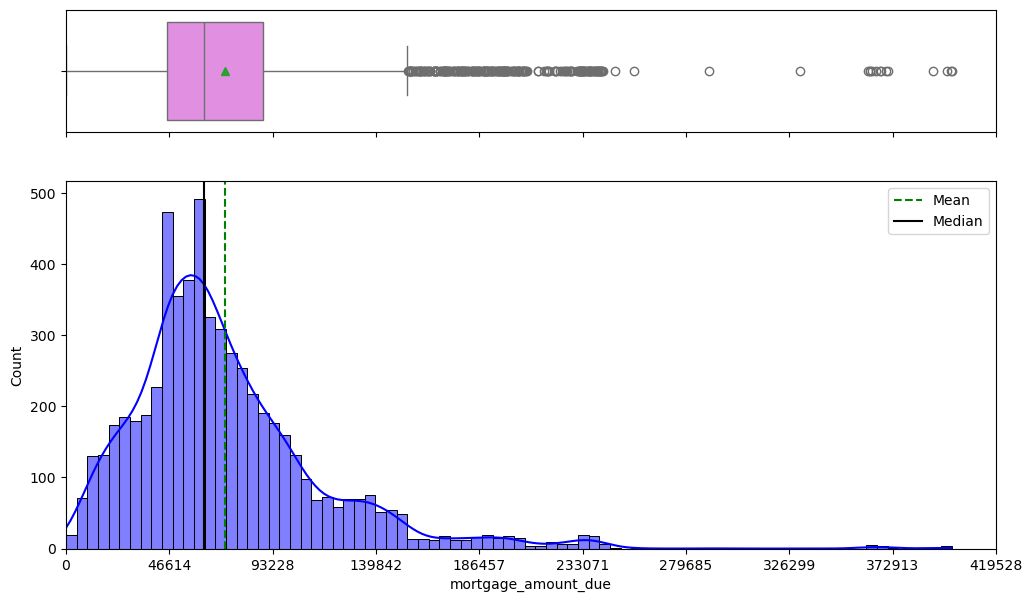

In [29]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[0])

#### Observation:
Mortgage amount due shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

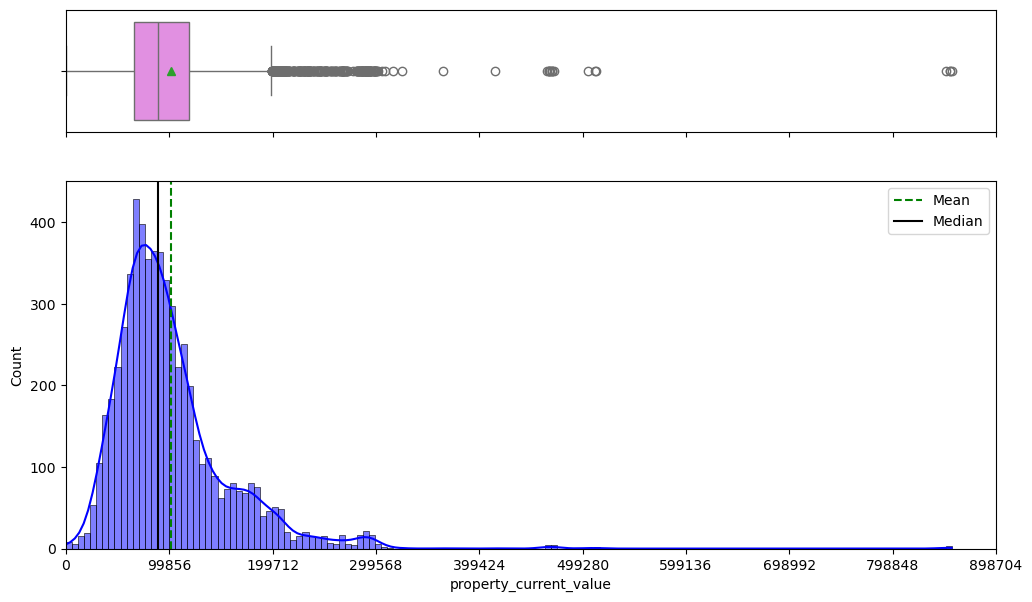

In [31]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[1])

#### Observation:
Current property value shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

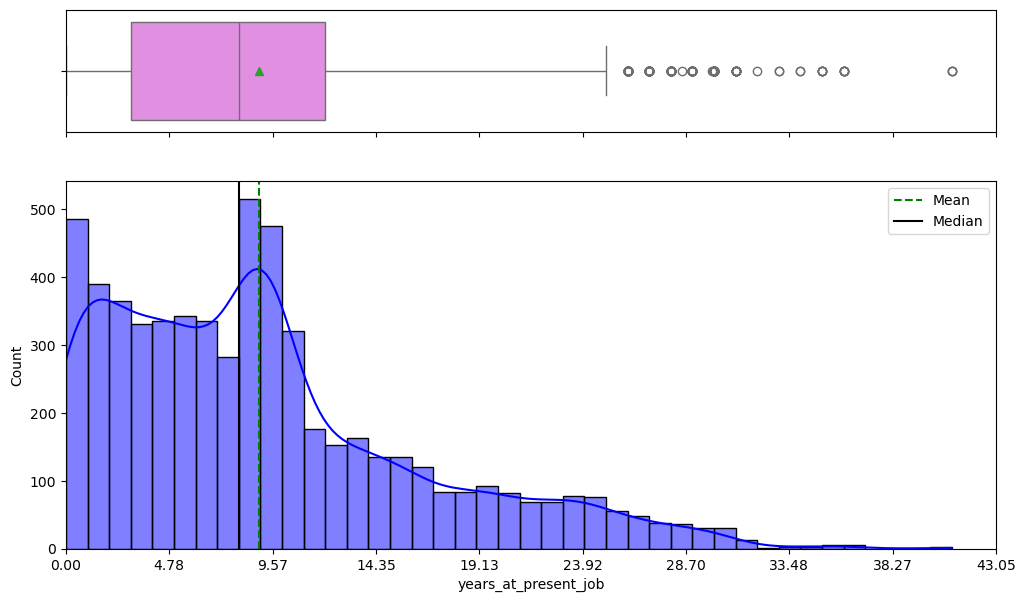

In [33]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[2])

#### Observation:
No of years at present job shows a moderately right skewed, multi-modal distribution, with a few outliers, indicating most loan requesters maybe in middle age group. Extreme outliers may have to be capped

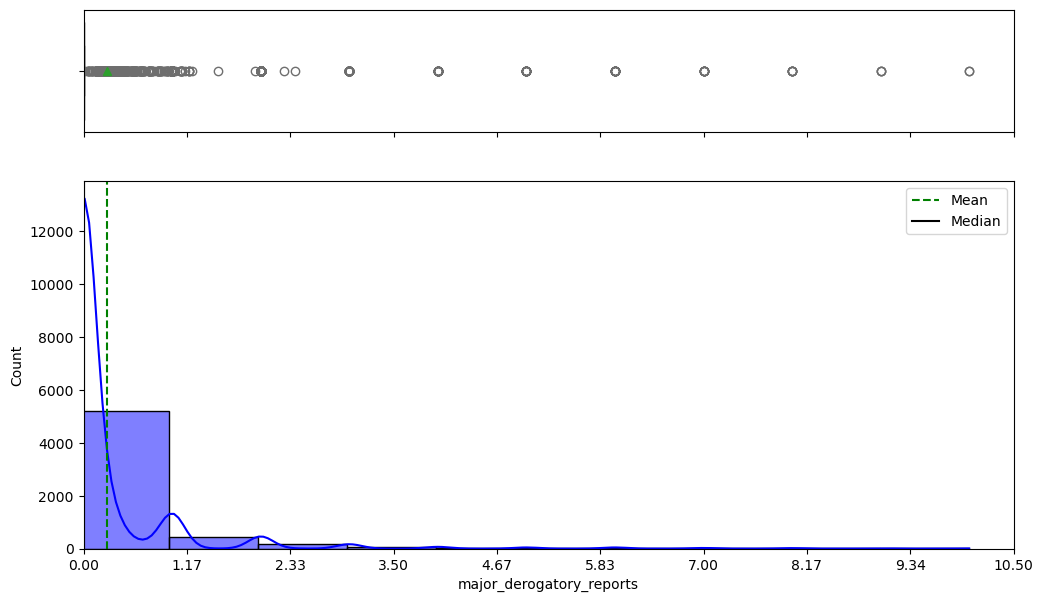

In [35]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[3])

#### Observations:
Major derogatory reports shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

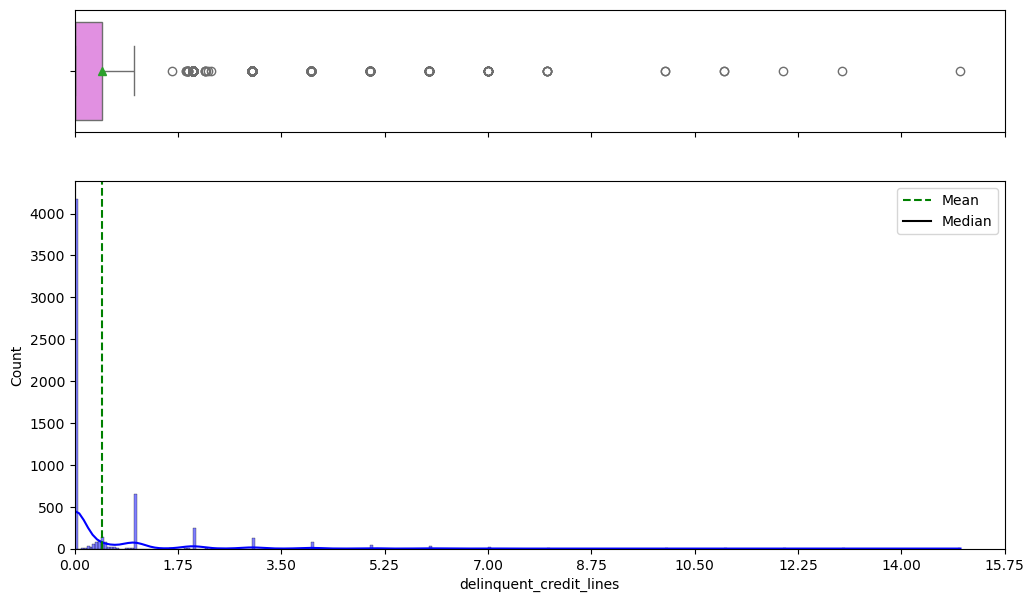

In [37]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[4])

#### Observations:
Delinquent credit lines shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

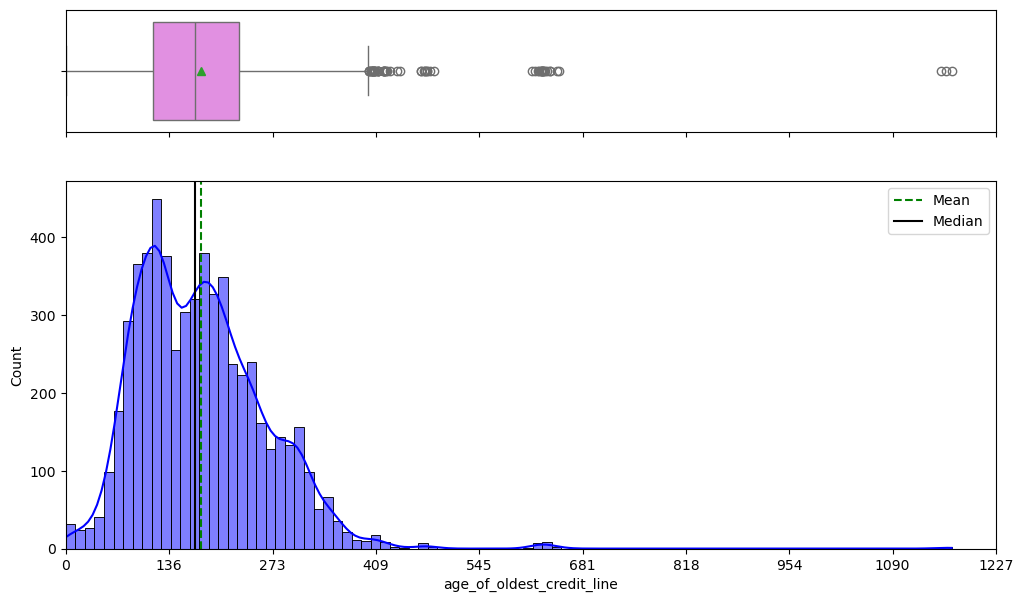

In [39]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[5])

#### Observation:
Oldest credit line shows fairly uniform bi-modal distribution, with quite a few outliers. What maybe of interest here are the loan requesters with low or zero age of credit line. Also extreme outliers may have to be capped

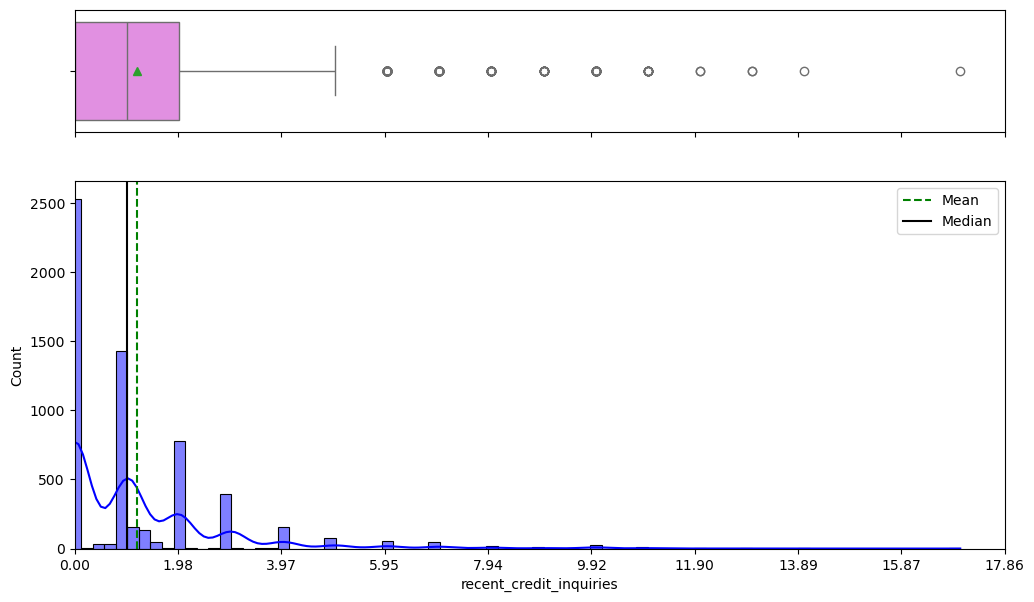

In [41]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[6])

#### Observations:
Recent credit inquiries shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

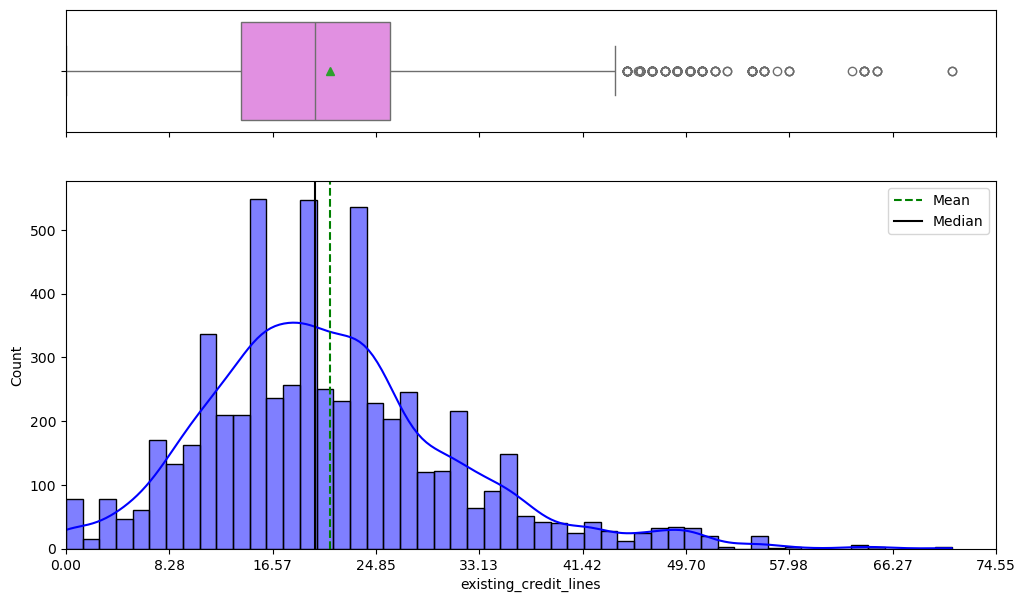

In [43]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[7])

#### Observations:
Existing credit lines shows a reasonably uniform distribution with slight right tail and a few outliers. Extreme outliers may need to be capped

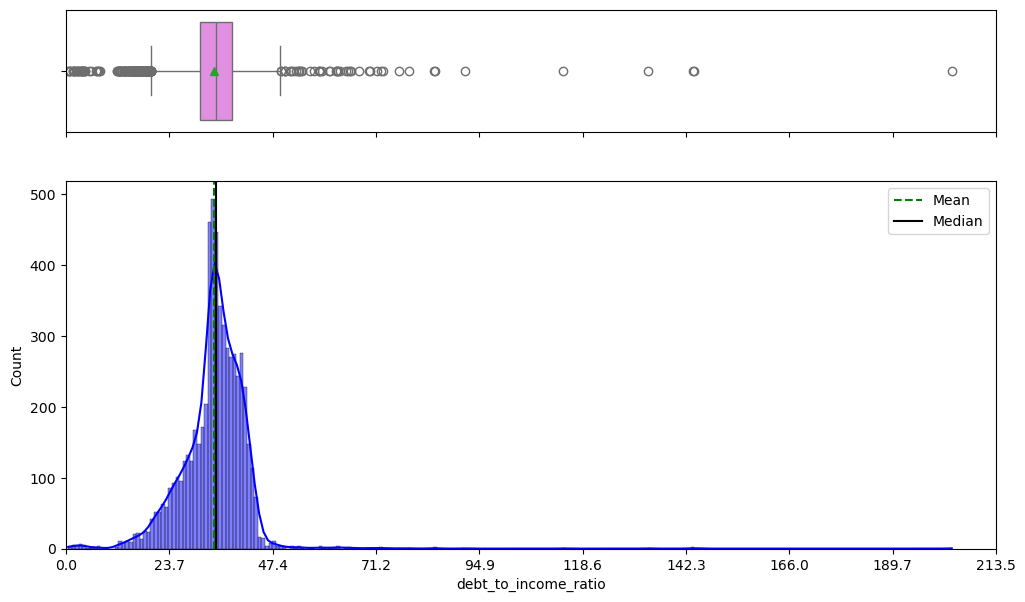

In [45]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[8])

#### Observations:
Debt to income ratio is slightly left skewed, with outliers on both sides. Extreme outlier on the high may need capping. Left skewness is a good thing as a low debt to income ratio is desirable
The distribution is also showing a sharp drop around ~ 40. Should investigate this further

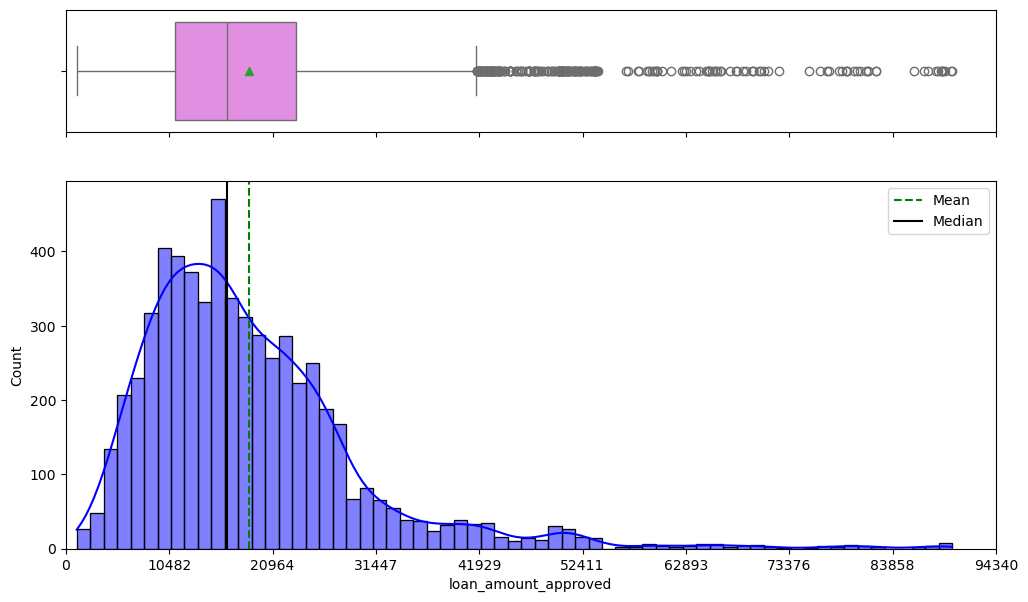

In [47]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[9])

#### Observation:
Amount of loan approved shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

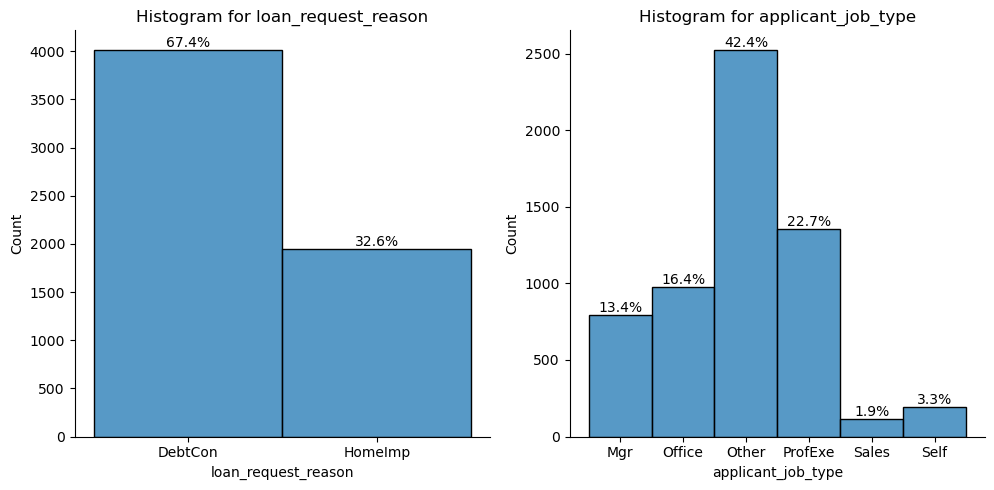

In [49]:
# Plot distribution of categorical columns
# Determine the number of rows and columns for subplots
numof_cols = len(cat_cols)
cols_per_row = 3  # Number of subplots per row
num_rows = math.ceil(numof_cols / cols_per_row)  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each column
for i, col in enumerate(cat_cols):
    sns.histplot(default_imputed, x=col, ax=axes[i])  # Use the corresponding subplot axis
    axes[i].set_title(f"Histogram for {col}")
    total = len(default_imputed[col])
    for bar in axes[i].patches:
        height = bar.get_height()
        percentage = (height / total) * 100  # Calculate percentage
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
    sns.despine()
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

#### Observations:
1. ~ 70% of requests are for debt consolidation, indication a fundamental bias in the dataset, or biased selection process
2. Majority (~ 45%) of the loan requests are from people who did not provide details of the profession, suggesting improvements in the data collection process

### **Bivariate Analysis**

### Check correlation for numeric variables

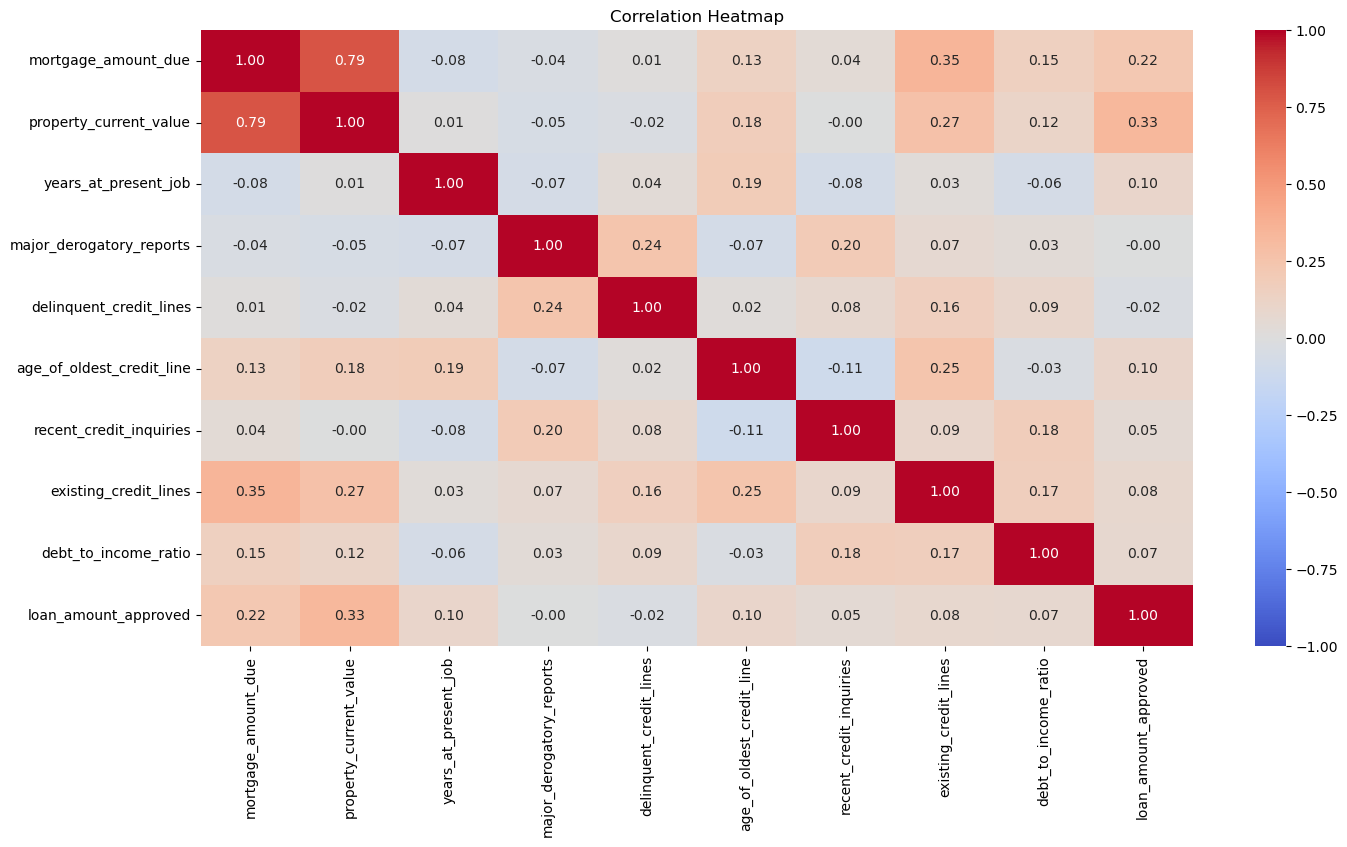

In [53]:
# Calculate the correlation matrix
correlation_matrix = default_imputed[num_cols].corr()
# Plot the heatmap
plt.figure(figsize=(16, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [54]:
# Sort correlations and exclude duplicates
sorted_unique_correlations = (
    correlation_matrix
    .stack()                            # Flatten the matrix into a Series
    .reset_index()                      # Reset index to access column pairs
    .rename(columns={0: 'correlation'})  # Rename correlation column
    .query("level_0 < level_1")         # Keep only one direction (unique pairs)
    .sort_values(by='correlation', ascending=False)  # Sort by correlation
)

print(sorted_unique_correlations)

                      level_0                   level_1  correlation
1         mortgage_amount_due    property_current_value     0.790887
70      existing_credit_lines       mortgage_amount_due     0.349659
91       loan_amount_approved    property_current_value     0.331023
71      existing_credit_lines    property_current_value     0.272398
57  age_of_oldest_credit_line     existing_credit_lines     0.245797
43    delinquent_credit_lines  major_derogatory_reports     0.243435
90       loan_amount_approved       mortgage_amount_due     0.221168
36   major_derogatory_reports   recent_credit_inquiries     0.195368
52  age_of_oldest_credit_line      years_at_present_job     0.194465
86       debt_to_income_ratio   recent_credit_inquiries     0.178886
51  age_of_oldest_credit_line    property_current_value     0.177635
87       debt_to_income_ratio     existing_credit_lines     0.167742
47    delinquent_credit_lines     existing_credit_lines     0.157910
80       debt_to_income_ratio     

#### Observations:
1. Property value as of date seems to have a strong +ve correlation to mortgage amount due. This is only possible if all if the mortgages in the dataset were approved around the same timeand the approved mortgage amount was a fixed % of the property value, irrespective of other factors. So age of the mortgage may be a useful feature (latent variable). Most other variables have weak correlations

### Let's check the distribution of numerical variables to loan defaults

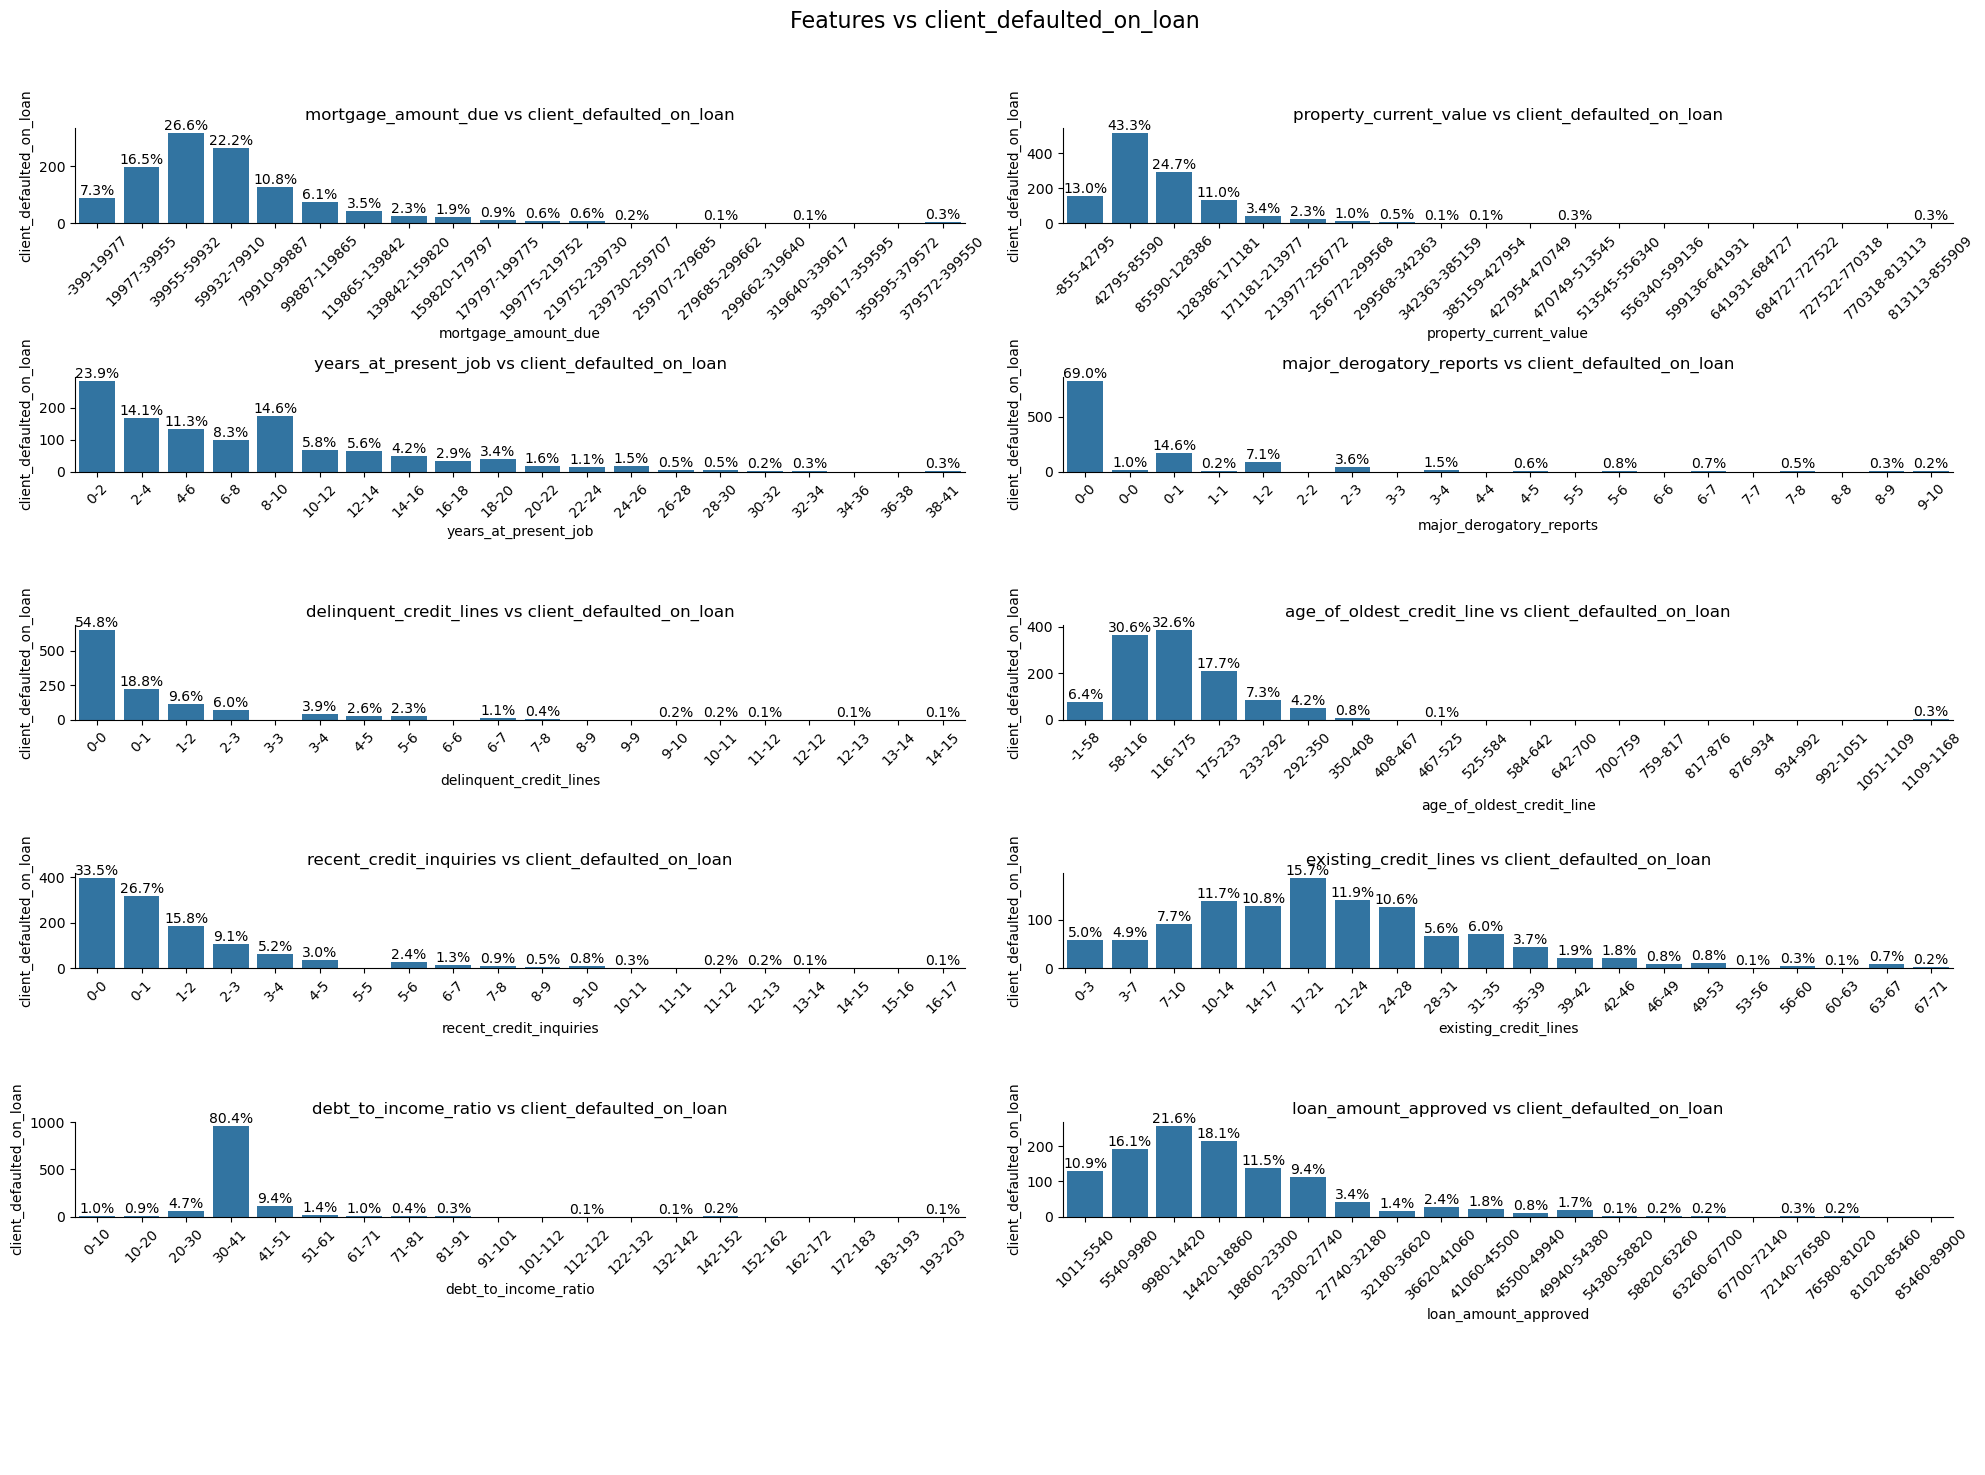

In [57]:
# Function to plot binned features
# Parameters:
# - `default`: DataFrame containing the data
# - `binned_cols_to_plot`: List of columns to be binned and plotted
# - `'client_defaulted_on_loan_num'`: Target variable for analysis (e.g., 1 = defaulted, 0 = not defaulted)
# - `40`: Number of bins to divide the numerical values into for plotting
plot_binned_features(default_imputed, num_cols, 'client_defaulted_on_loan', 20)

#### Observations
1. No of defaulters are highest where recent credit inquiries, delinquent credit lines, major derogatory reports are the lowest. This seems counter intuitive at first, how ever this is most likely due to these customers not having any credit records at all. This will happen if these customers were denied credit in the past and have not applied for credit in the recent time (for the duration during which this data was collected). Additional data is required to understand this anamoly - gross income, demographics, macroeconomic factors such severe recession or other financial distress
2. Default rate is the extra-ordinarily high (80%) for customers with debt to income ratio between 30-41. Understanding this anomaly likely requires a more detailed analysis of the borrower behavior and external conditions. This data set is insufficient for such analysis, as was commented in no 1 above
3. 


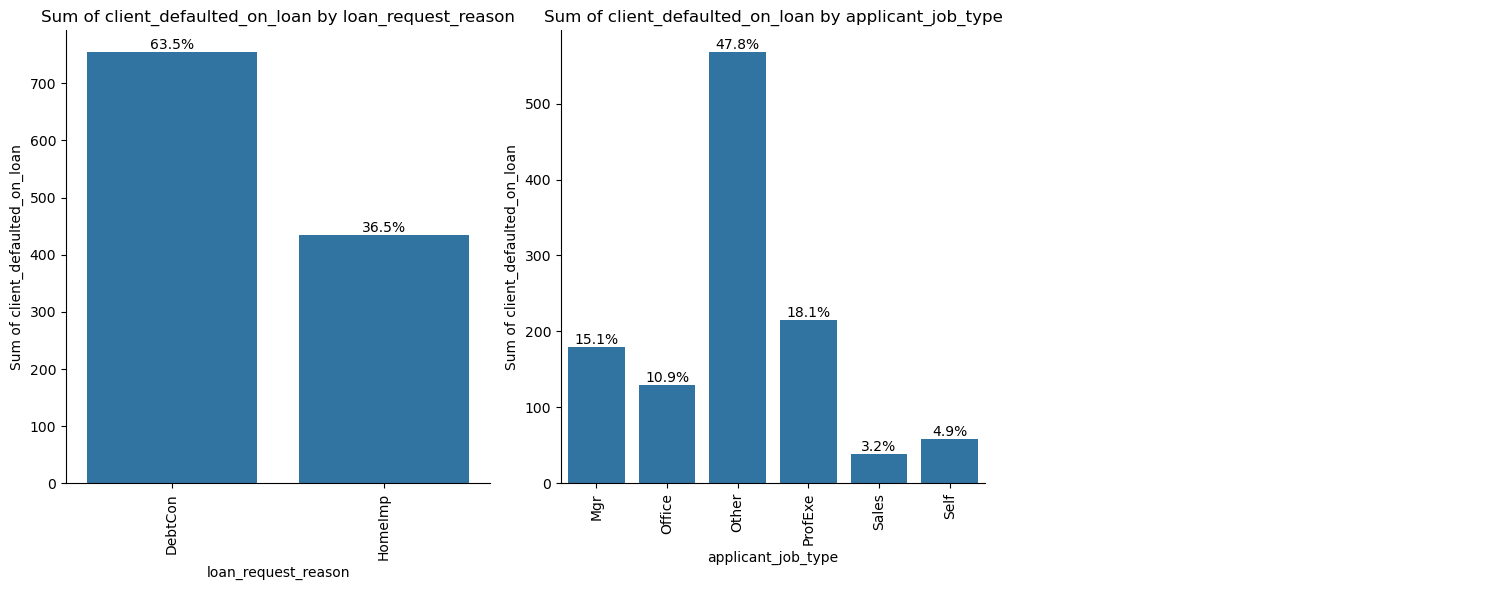

In [59]:
plot_grouped_barplots(default_imputed, cat_cols, 'client_defaulted_on_loan')

#### Observations:


In [61]:
# Perform the Chi-squared test
results = chi_squared_test(default_imputed, 'client_defaulted_on_loan')
print(results)

                      Feature       P-value  Significant
7     delinquent_credit_lines  1.486104e-76         True
6    major_derogatory_reports  7.429682e-76         True
9     recent_credit_inquiries  2.387766e-32         True
8   age_of_oldest_credit_line  2.436912e-24         True
10      existing_credit_lines  1.064742e-16         True
4          applicant_job_type  9.718614e-16         True
11       debt_to_income_ratio  1.282800e-09         True
0        loan_amount_approved  1.444350e-09         True
2      property_current_value  1.666966e-07         True
5        years_at_present_job  9.911691e-05         True
1         mortgage_amount_due  3.685567e-04         True
3         loan_request_reason  1.511726e-03         True


#### Observation:
All the available features are significant for the prediction of target variable

In [63]:
# Calculate correlation matrix and VIF, excluding the target variable
corr_matrix, vif_values = calculate_corr_and_vif(default_imputed)

# Display results
print("Correlation Matrix:")

sorted_corr_matrix = corr_matrix[corr_matrix.columns[corr_matrix.iloc[0].argsort()[::-1]]]

sorted_corr_matrix

Correlation Matrix:


,client_defaulted_on_loan,delinquent_credit_lines,major_derogatory_reports,recent_credit_inquiries,debt_to_income_ratio,existing_credit_lines,mortgage_amount_due,property_current_value,years_at_present_job,loan_amount_approved,age_of_oldest_credit_line
client_defaulted_on_loan,1.000000,0.340649,0.262940,0.170484,0.161515,-0.004328,-0.036432,-0.047251,-0.058326,-0.075099,-0.160719
loan_amount_approved,-0.075099,-0.024980,-0.001385,0.049314,0.073985,0.083895,0.221168,0.331023,0.099529,1.000000,0.095525
mortgage_amount_due,-0.036432,0.009226,-0.035373,0.042200,0.153429,0.349659,1.000000,0.790887,-0.075417,0.221168,0.133062
property_current_value,-0.047251,-0.024814,-0.048203,-0.004552,0.117041,0.272398,0.790887,1.000000,0.006576,0.331023,0.177635
years_at_present_job,-0.058326,0.036177,-0.068878,-0.075752,-0.064296,0.027413,-0.075417,0.006576,1.000000,0.099529,0.194465
major_derogatory_reports,0.262940,0.243435,1.000000,0.195368,0.032526,0.065917,-0.035373,-0.048203,-0.068878,-0.001385,-0.071847
delinquent_credit_lines,0.340649,1.000000,0.243435,0.076932,0.091081,0.157910,0.009226,-0.024814,0.036177,-0.024980,0.020831
age_of_oldest_credit_line,-0.160719,0.020831,-0.071847,-0.105872,-0.027876,0.245797,0.133062,0.177635,0.194465,0.095525,1.000000
recent_credit_inquiries,0.170484,0.076932,0.195368,1.000000,0.178886,0.088843,0.042200,-0.004552,-0.075752,0.049314,-0.105872
existing_credit_lines,-0.004328,0.157910,0.065917,0.088843,0.167742,1.000000,0.349659,0.272398,0.027413,0.083895,0.245797


In [64]:
print("\nVIF Values:")
print(vif_values)


VIF Values:
                      Feature        VIF
0    client_defaulted_on_loan   1.566566
1        loan_amount_approved   4.239925
2         mortgage_amount_due  10.770356
3      property_current_value  12.067502
4        years_at_present_job   2.606674
5    major_derogatory_reports   1.269580
6     delinquent_credit_lines   1.418846
7   age_of_oldest_credit_line   5.664523
8     recent_credit_inquiries   1.670832
9       existing_credit_lines   6.722556
10       debt_to_income_ratio   9.646728


### **Multivariate Analysis**

#### Multivariate analysis using PCA

In [67]:
# Standardize the data
scaler = StandardScaler()
default_imputed_num = default_imputed_num.drop('client_defaulted_on_loan', axis=1)
default_imputed_scaled = pd.DataFrame(scaler.fit_transform(default_imputed_num), columns=default_imputed_num.columns)

In [68]:
# Apply PCA
pca = PCA(n_components=10)  # Reduce to 10 principal components
default_pca = pd.DataFrame(pca.fit_transform(default_imputed_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

In [69]:
default_pca.shape

(5960, 10)

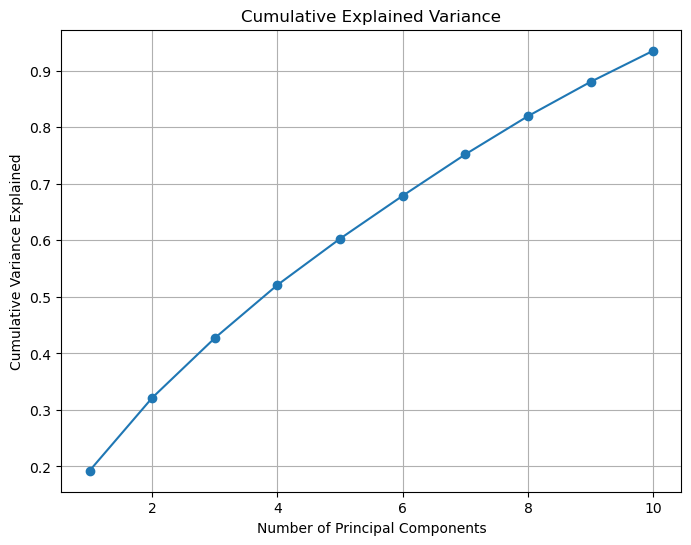

PC1: 19.25%
PC2: 12.91%
PC3: 10.57%
PC4: 9.39%
PC5: 8.18%
PC6: 7.60%
PC7: 7.33%
PC8: 6.76%
PC9: 6.07%
PC10: 5.51%


In [70]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

# Print explained variance by each component
for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ratio:.2%}")

In [71]:
loadings = pd.DataFrame(pca.components_, columns=default_imputed_scaled.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])
sorted_loadings = loadings[loadings.columns[loadings.iloc[0].argsort()[::-1]]]
sorted_loadings

,property_current_value,mortgage_amount_due,existing_credit_lines,loan_amount_approved,age_of_oldest_credit_line,debt_to_income_ratio,applicant_job_type,recent_credit_inquiries,delinquent_credit_lines,years_at_present_job,major_derogatory_reports,loan_request_reason
PC1,0.564349,0.562038,0.377765,0.310346,0.224839,0.187926,0.164539,0.063334,0.046180,0.016325,-0.010141,-0.084542
PC2,-0.115709,-0.024406,0.154508,-0.033094,-0.283461,0.337952,-0.176497,0.507888,0.364951,-0.256928,0.470624,-0.238110
PC3,-0.131973,-0.155981,0.290214,-0.105474,0.475466,-0.053059,-0.074089,-0.084675,0.502101,0.482677,0.254355,0.267552
PC4,0.113526,0.157519,-0.012058,-0.416300,-0.118282,-0.033377,0.438607,-0.122087,0.147134,-0.420538,0.204918,0.570938
PC5,-0.049854,0.067548,0.266224,-0.473751,0.134931,0.494769,-0.434851,-0.070441,-0.087126,-0.144030,-0.448635,0.104726
PC6,0.064956,-0.054320,-0.347036,0.267542,-0.156625,0.510445,0.041759,0.279827,-0.105172,0.371990,-0.047026,0.532949
PC7,-0.287939,-0.257119,0.248540,-0.086183,0.248189,0.227032,0.688777,0.286145,-0.202967,0.020438,-0.170528,-0.204090
PC8,0.069004,0.080474,0.070728,-0.188016,0.284369,-0.368026,-0.238102,0.569180,-0.506208,-0.005324,0.217191,0.219081
PC9,0.123336,0.204166,0.086827,-0.412575,-0.480159,-0.254670,0.123744,0.269465,0.191500,0.490740,-0.303821,-0.110492
PC10,0.018998,0.042160,0.192261,-0.226520,-0.233858,0.240180,0.033534,-0.390421,-0.475873,0.338804,0.532076,-0.138952


In [72]:
default_imputed_scaled_noPV = default_imputed_scaled.drop(['property_current_value', 'debt_to_income_ratio'], axis=1)

In [73]:
# Apply PCA
pca_nopv = PCA(n_components=10)  # First 10 PCs
default_pcanopv = pd.DataFrame(pca_nopv.fit_transform(default_imputed_scaled_noPV), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

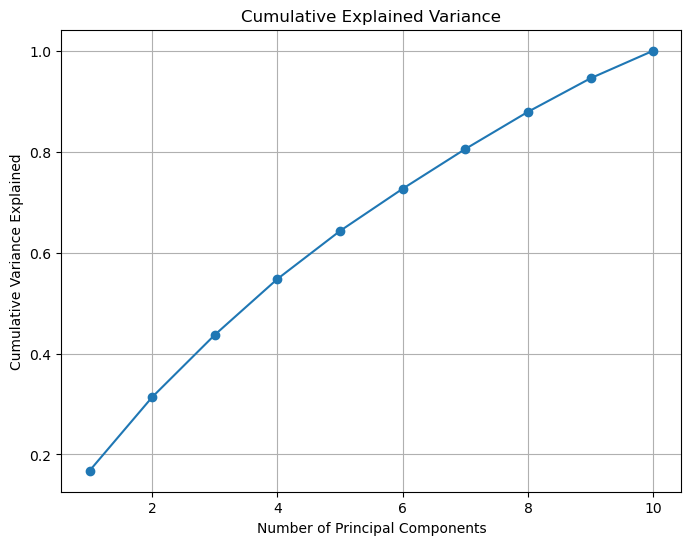

PC1: 19.25%
PC2: 12.91%
PC3: 10.57%
PC4: 9.39%
PC5: 8.18%
PC6: 7.60%
PC7: 7.33%
PC8: 6.76%
PC9: 6.07%
PC10: 5.51%


In [74]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_nopv.explained_variance_ratio_) + 1), np.cumsum(pca_nopv.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

# Print explained variance by each component
for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ratio:.2%}")

In [75]:
loadings_noPV = pd.DataFrame(pca_nopv.components_, columns=default_imputed_scaled_noPV.columns, index=[f'PC{i+1}' for i in range(len(pca_nopv.components_))])
sorted_loadings_noPV = loadings_noPV[loadings_noPV.columns[loadings_noPV.iloc[0].argsort()[::-1]]]
sorted_loadings_noPV

,existing_credit_lines,mortgage_amount_due,loan_amount_approved,age_of_oldest_credit_line,applicant_job_type,delinquent_credit_lines,recent_credit_inquiries,years_at_present_job,major_derogatory_reports,loan_request_reason
PC1,0.564944,0.536273,0.371776,0.364385,0.189912,0.166310,0.125781,0.085605,0.069998,-0.174589
PC2,0.068922,-0.044227,-0.064648,-0.364479,-0.181175,0.359962,0.506213,-0.310280,0.533091,-0.239083
PC3,0.127152,-0.230925,-0.271217,0.332329,-0.109147,0.523212,-0.111494,0.403770,0.305703,0.438092
PC4,0.082323,0.239478,-0.339450,-0.085858,0.570052,0.025279,-0.111467,-0.514367,0.093981,0.449273
PC5,-0.375277,-0.141912,0.535648,-0.146004,0.546317,-0.001119,0.149286,0.310268,0.298003,0.158018
PC6,0.074119,0.012024,-0.184326,0.201812,-0.071254,-0.475658,0.733955,0.145248,-0.049124,0.355148
PC7,-0.157513,0.358214,0.430337,-0.103036,-0.536355,-0.023924,-0.134733,-0.198701,0.119840,0.539277
PC8,-0.061382,-0.251194,0.075951,0.552172,-0.043017,-0.386884,-0.198258,-0.332244,0.544036,-0.158977
PC9,0.264722,0.240616,-0.231703,-0.423667,-0.033571,-0.425092,-0.284422,0.424031,0.440926,-0.043612
PC10,0.638874,-0.574616,0.321370,-0.243956,0.006594,-0.105692,-0.061156,-0.147516,-0.112499,0.222468


## Treating Outliers

## Treating Missing Values: See section 1.6.1.1

## **Important Insights from EDA**

What are the the most important observations and insights from the data based on the EDA performed?

## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

### Logistic Regression

### Decision Tree

### **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

You can learn about more Hyperpapameters on this link and try to tune them. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


### **Building a Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

### **Random Forest Classifier Hyperparameter Tuning**

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success):** 
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**2. Refined insights:** 
- What are the most meaningful insights relevant to the problem?

**3. Proposal for the final solution design:** 
- What model do you propose to be adopted? Why is this the best solution to adopt?